In [1]:
import argparse, os, sys, glob
import PIL
import cv2
import torch
import torch.nn as nn
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange, repeat
from torchvision.utils import make_grid
from torch import autocast
from contextlib import nullcontext
import time
import einops
from pytorch_lightning import seed_everything
from torchvision.utils import save_image
sys.path.append(os.path.dirname(sys.path[0]))
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from transformers import CLIPProcessor, CLIPModel
from cldm.model import create_model, load_state_dict

/home/trangnguyenphuong/miniconda3/envs/ldm/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/trangnguyenphuong/miniconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
class CannyDetector:
    def __call__(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.to(device)
    model.eval()
    return model

def load_img(path):
    image = Image.open(path).convert("RGB")
    w, h = image.size
    print(f"loaded input image of size ({w}, {h}) from {path}")
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((512,512), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

In [20]:
apply_canny = CannyDetector()
config="configs/stable-diffusion/v1-inference.yaml"
ckpt="models/sd1.5/v1-5-pruned.ckpt"
config = OmegaConf.load(f"{config}")
model = load_model_from_config(config, f"{ckpt}")
sampler = DDIMSampler(model)
canny_model_path = "./models/controlnet/control_v11p_sd15_canny.pth"

Loading model from models/sd1.5/v1-5-pruned.ckpt


/tmp/ipykernel_55184/3250919737.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pl_sd = torch.load(ckpt, map_location="cpu")


Global Step: 840000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
make_beta_schedule:linear
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels


In [ ]:
def main(
    prompt='', 
    content_dir=None, 
    ddim_steps=50, 
    strength=0.5, 
    ddim_eta=0.0, 
    n_iter=1,
    C=4, 
    f=8, 
    n_rows=0,
    scale=10.0,
    model=None, seed=42, prospect_words=None, n_samples=1, height=512, width=512):
    precision = "autocast"
    outdir = "outputs/comparison"
    seed_everything(seed)


    controlnet_canny = create_model(
        './configs/controlnet/control_canny.yaml')
    model_resume_state = torch.load(canny_model_path, map_location='cpu')
    
    os.makedirs(outdir, exist_ok=True)
    outpath = outdir

    batch_size = n_samples
    n_rows = n_rows if n_rows > 0 else batch_size
    data = [batch_size * [prompt]]

    sample_path = os.path.join(outpath, "samples")
    os.makedirs(sample_path, exist_ok=True)
    base_count = len(os.listdir(sample_path))
    grid_count = len(os.listdir(outpath)) + 10

    if content_dir is not None:
        content_name = content_dir.split('/')[-1].split('.')[0]
        content_image = load_img(content_dir).to(device)
        content_image = repeat(content_image, '1 ... -> b ...', b=batch_size)
        content_latent = model.get_first_stage_encoding(model.encode_first_stage(content_image))  # move to latent space

        init_latent = content_latent

    sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)

    assert 0. <= strength <= 1., 'can only work with strength in [0.0, 1.0]'
    t_enc = int(strength * ddim_steps)
    print(f"target t_enc is {t_enc} steps")


    test = False
    precision_scope = autocast if precision == "autocast" else nullcontext
    with torch.no_grad():
        with precision_scope(device.type):
            with model.ema_scope():
                tic = time.time()
                all_samples = list()
                for n in trange(n_iter, desc="Sampling"):
                    for prompts in tqdm(data, desc="data"):
                        uc = None
                        if scale != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""])
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)
                        
                        c = model.get_learned_conditioning(prompts, prospect_words=prospect_words)
                        img = cv2.imread(content_dir)
                        img = cv2.resize(img, (512, 512))
                        # H, W, C = img.shape
                        detected_map = apply_canny(img, 100, 200)  # 100  200
                        # cv2.imwrite('out.png', detected_map)
                        image = detected_map[:, :, None]
                        image = np.concatenate([image, image, image], axis=2)
                        # img1 = rearrange(detected_map, 'h w c ->c h w')

                        control = torch.from_numpy(image.copy()).float().to(device) / 255.0
                        control = torch.stack([control for _ in range(n_samples)], dim=0)
                        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

                        if not test:
                            print(control.shape)
                            print(type(control))
                            test = True
                            
                        new_state_dict = {}
                        for key, value in model_resume_state.items():
                            if key.startswith('control_model.'):
                                new_key = key[len('control_model.'):]
                                new_state_dict[new_key] = value
                        controlnet_canny.load_state_dict(new_state_dict)
                        controlnet_canny = controlnet_canny.to(device)
                    

                        z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc] * batch_size).to(device))
                        t_enc = int(strength * ddim_steps)
                        samples = sampler.decode(z_enc, c, t_enc, controlnet_canny, control, unconditional_guidance_scale=scale,unconditional_conditioning=uc,)
                        
                        x_samples = model.decode_first_stage(samples)

                        x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                        for x_sample in x_samples:
                            x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                            base_count += 1
                        all_samples.append(x_samples)

                # additionally, save as grid
                grid = torch.stack(all_samples, 0)
                grid = rearrange(grid, 'n b c h w -> (n b) c h w')
                grid = make_grid(grid, nrow=n_rows)

                # to image
                grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
                output = Image.fromarray(grid.astype(np.uint8))
                output.save(os.path.join(outpath, content_name + 'stylized.jpg'))
                grid_count += 1

                toc = time.time()
    return output 

In [24]:
model.embedding_manager.load('logs/train2025-06-27T20-47-12_test/checkpoints/embeddings_gs-42399.pt')
model = model.to(device)

# main(prompt = '*', content_dir = contentdir, style_dir = contentdir, ddim_steps = 50, strength = 0.7, seed=42, model = model)
main(prompt = '*', \
    content_dir = "data/test_data/woman1.jpg", \
    ddim_steps = 50, \
    strength = 0.7, \
    seed=41, \
    height = 512, \
    width = 768, \
    prospect_words = ['*'],
    model = model,\
    )

Global seed set to 41


Loaded model config from [./configs/controlnet/control_canny.yaml]


/tmp/ipykernel_55184/75000144.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_resume_state = torch.load(canny_model_path, map_location='cpu')


loaded input image of size (3000, 2000) from data/test_data/woman1.jpg
target t_enc is 35 steps


Sampling:   0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:2 and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

# Visualize metrics

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import argparse

def visualize_metrics(metrics_csv, output_dir='outputs', loss='train/loss_step'):
    metrics_df = pd.read_csv(metrics_csv) if isinstance(metrics_csv, str) else metrics_csv
    metrics_df.dropna(inplace=True)
    metrics_df['global_step'] = metrics_df['global_step'].astype(int)

    plt.plot(metrics_df['global_step'], metrics_df[loss], label='train/loss', color='blue')
    os.makedirs(output_dir, exist_ok=True)
    plt.show()
    plt.savefig(os.path.join(output_dir, '.png'))

In [16]:
metrics_df = pd.read_csv('logs/train2025-06-30-08-01-09_v1-finetune/testtube/version_0/metrics.csv')
metrics_df.head()

,lr-AdamW,created_at,train/loss_simple_step,train/loss_vlb_step,train/loss_step,global_step,epoch,val/loss_simple,val/loss_vlb,val/loss,val/loss_simple_ema,val/loss_vlb_ema,val/loss_ema,train/loss_simple_epoch,train/loss_vlb_epoch,train/loss_epoch
0,0.000002,2025-06-30 08:03:51.713686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2025-06-30 08:03:53.089168,0.044243,0.000145,0.044243,49.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000002,2025-06-30 08:05:04.784864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,2025-06-30 08:05:05.859148,0.022781,0.000078,0.022781,99.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000002,2025-06-30 08:06:14.685186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
metrics_df.dropna(subset=['global_step'], inplace=True)

In [18]:
metrics_df.head()

,lr-AdamW,created_at,train/loss_simple_step,train/loss_vlb_step,train/loss_step,global_step,epoch,val/loss_simple,val/loss_vlb,val/loss,val/loss_simple_ema,val/loss_vlb_ema,val/loss_ema,train/loss_simple_epoch,train/loss_vlb_epoch,train/loss_epoch
1,NaN,2025-06-30 08:03:53.089168,0.044243,0.000145,0.044243,49.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,2025-06-30 08:05:05.859148,0.022781,0.000078,0.022781,99.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,2025-06-30 08:06:16.182757,0.028336,0.000102,0.028336,149.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,2025-06-30 08:07:22.339449,0.007799,0.000038,0.007799,199.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,2025-06-30 08:08:27.994223,0.035164,0.000116,0.035164,249.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


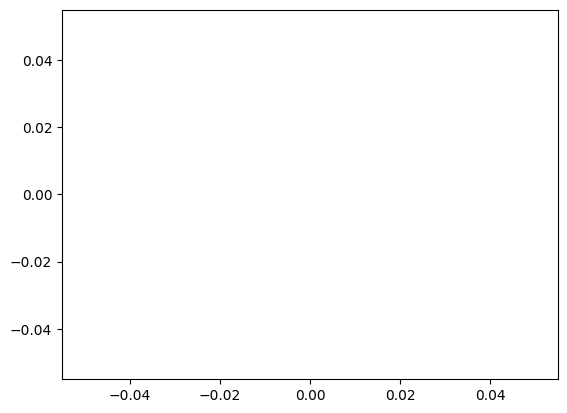

<Figure size 640x480 with 0 Axes>

In [19]:
visualize_metrics(metrics_df, loss='train/loss_step')

In [22]:
import re
embed_dir = 'logs/train2025-06-30-08-01-09_v1-finetune/testtube/version_0/checkpoints/embeddings_gs-4499.pt'
match = re.search(r'(gs-\d+)', embed_dir)
if match:
    result = match.group(1)
    print(result)  # Output: gs-49999

gs-4499


In [23]:
data_dir = 'data/pixta_data/123753_3/train'
from pathlib import Path
data_dir = Path(data_dir)
images = list(data_dir.glob('*.jpg'))
size = len(images)
size

90